# IMPORT REQUIRED LIBRARIES

In [1]:
import os
import pandas as pd
import numpy as np
import shutil
import random
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from os import listdir
from matplotlib import image
from skimage.color import rgb2gray
from PIL import Image
import cv2
import imutils
import tensorflow.keras.backend as K
import image_features_extraction.Images as fe
from image_features_extraction import Regions
import cv2

# DATA AUGMENTATION

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

categories = ['val', 'train', 'test']

for category in categories:
    path = root_dir + category
    labels = ['yes', 'no']
    for label in labels:
        path = root_dir + category
        path = path + '/'+label
        for filename in listdir(path):
           
            datagen = ImageDataGenerator(
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

            img = load_img(path + '/' + filename)  # data type : PIL image
            x = img_to_array(img)                  # Numpy array with shape (3, 150, 150)
            x = x.reshape((1,) + x.shape)          # Numpy array with shape (1, 3, 150, 150)

            # the .flow() command below : used to generate batches of randomly transformed images
            # and saves the results to the  directory
            i = 0
            for batch in datagen.flow(x, batch_size=1,
                                      save_to_dir='augmented/' + label, save_prefix=label, save_format='jpeg'):
                i += 1
                if i > 8:
                    break  
            #break
        #break
    #break

# EXTRACT FEATURES

In [2]:
from xtract_features.extract import s_entropy, entropy_simple
from xtract_features.region_props import *

def extract_features(thresh):
    
    # INTENSITY FEATURES
    val = 0
    black_pixels_sum = 0
    black_pixels_cnt = 0
    for k in range(0, len(thresh)):
        for l in range(0, len(thresh[k])):
            val = val + thresh[k][l]
            if (thresh[k][l] < 127):
                black_pixels_sum = black_pixels_sum + thresh[k][l] 
                black_pixles_cnt = black_pixels_cnt + 1

    avg = val/(len(thresh) * len(thresh[0]))
    #print(avg)


    # REGION FEATURES
    _rp = region_props(thresh)
    max_area = _rp.max_area()   # calculates the maximum area region
    perimeter = _rp.perimeter()
    eccentricity = _rp.eccentricity()
    eq_diameter = _rp.eq_diameter()
    solidity = _rp.solidity()
    convex_area = _rp.convex_area_r()
    maj_axis_len = _rp.maj_ax_len()
    min_axis_len = _rp.min_ax_len()
    #orientation = _rp.orient()
    
    # calculates shannon's entropy
    s_entr = s_entropy(thresh)
    # calculates simple entropy
    entr_simp = entropy_simple(thresh)

    features = [max_area, perimeter, eccentricity, eq_diameter, solidity, convex_area, maj_axis_len, min_axis_len, s_entr, entr_simp, val, avg, black_pixels_sum, black_pixels_cnt]
    return features
    

# DISPLAY FEATURES

In [19]:
def plot_features(thresh):
    _rp = region_props(thresh)
    #print(max_area)
    #plot regions
    _rp.plot_image()
     #plots in black and white
    _rp.plot_show_bw()
     #plot with lables
    _rp.plot_image_with_label()
    # returns the mean of areas of all the regions
    print(_rp.mean_area())
    # eccentricity of the highest area region
    print(_rp.eccentricity())
    


# PLOT IMAGES 

In [4]:
def plot_images(original_img, intermediate1, intermediate2, intermediate3, thresh):
    f = plt.figure(figsize = (20, 20))
    f.add_subplot(3,2, 1)
    plt.imshow(np.rot90(original_img, 2), cmap = 'gray')
    f.add_subplot(3,2, 2)
    plt.imshow(np.rot90(intermediate1, 2), cmap = 'gray')
    f.add_subplot(3,2, 3)
    plt.imshow(np.rot90(intermediate2, 2), cmap = 'gray')
    f.add_subplot(3,2, 4)
    plt.imshow(np.rot90(intermediate3, 2), cmap = 'gray')
    f.add_subplot(3,2, 5)
    plt.imshow(np.rot90(thresh, 2), cmap = 'gray')
    #f.add_subplot(2,3, 6)
    #plt.imshow(np.rot90(thresh_gray, 2))

# IMAGE PREPROCESSING, SEGMENTATION AND FEATURE EXTRACTION

IMAGES WITH TUMOR
IMAGES WITHOUT BRAIN TUMOR


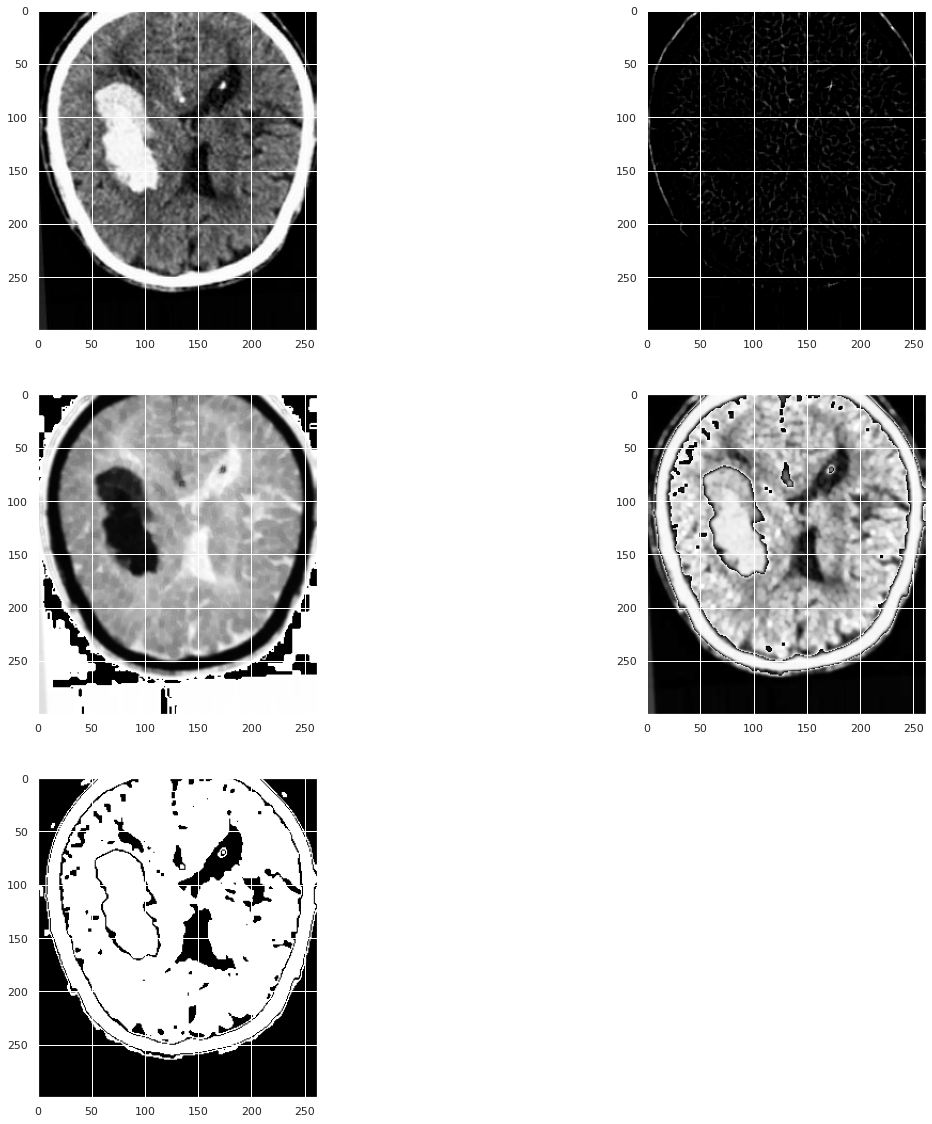

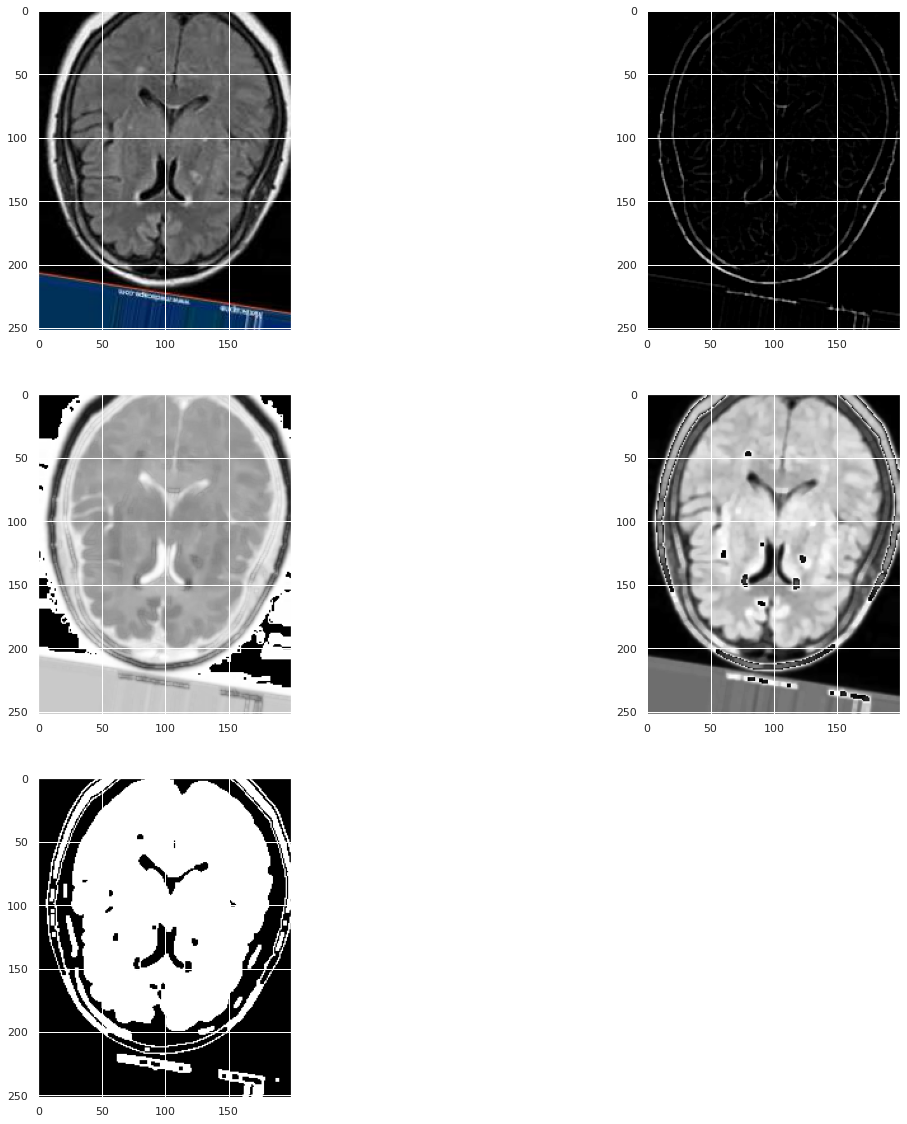

In [7]:


X_train = []
y_train = []
X_test = []
y_test = []
ycnt = 0
ncnt = 0
plot_yes = False
plot_no = False

#root = 'home/abhinav/my_project_dir/my_project_env/augmented'
root = '/home/abhinav/my_project_dir/my_project_env/augmented'
labels = ['yes', 'no']

for label in labels:
    path = root
    path = path + '/'+ label
    for filename in listdir(path):
        original_img = cv2.imread(path + '/' + filename)
        #image = temp_img2

        #temp_img2 = rgb2gray(temp_img2) or
        gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
       
        # MORPHOLOGICAL OPERATIONS
        kernel = np.ones((3, 3), np.uint8)
        erosion = cv2.erode(gray, kernel,iterations = 2)
        opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
        closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

        # PIXEL SUBTRACTION
        intermediate1 = gray - opening
        intermediate2 = intermediate1 - opening
        intermediate3 = gray - intermediate2

        #IMAGE SEGMENTATION USING OTSU'S THRESHOLD TECHNIQUE
        intermediate3 = np.array(intermediate3, dtype=np.uint8)
        #  converting to gray scale other method
        gray1 = intermediate3
        ret, thresh = cv2.threshold(gray1, 117, 200, cv2.THRESH_OTSU)
        
        # PLOT IMAGE AFTER SEGMENTATION
        #thresh = np.array(thresh)
        #thresh2 = K.constant(thresh)
        #plt.imshow(thresh)
        #print(thresh)
        
        
        #PLOT IMAGES
        if (not plot_yes and label == 'yes'):
            print("IMAGES WITH TUMOR")
            plot_images(original_img, intermediate1, intermediate2, intermediate3, thresh)
            plot_yes = True
        if (not plot_no and label == 'no'):
            print('IMAGES WITHOUT BRAIN TUMOR')
            plot_images(original_img, intermediate1, intermediate2, intermediate3, thresh)
            plot_no = True
        
        
        # GET EXTRACTED FEATURES
        features = extract_features(thresh)

        # DIVIDE DATASET INTO TRAINING AND TEST SET
        # TOTAL IMAGE COUNT = 5046
        # NO OF IMAGES IN TRAIN SET : 2145 (YES), 2145(NO)
        # NO OF IMAGES IN TEST SET : 378 (YES), 378(NO)
        if (label == 'yes'):
            if (ycnt < 2145):
                y_train.append(1)
                X_train.append(features)
                ycnt = ycnt + 1
            elif (ycnt <= 2523):
                y_test.append(1)
                X_test.append(features)
            
        if (label == 'no'):
            if (ncnt < 2145):
                y_train.append(0)
                X_train.append(features)
                ncnt = ncnt + 1
            else : 
                y_test.append(0)
                X_test.append(features)

        #break
    #break
                    
                    
#print(len(X))
#print(len(X_train), len(y_train))

# INPUT EXRACTED FEATURES TO THE CLASSIFIER

RANDOM FOREST CLASSIFIER model accuracy(in %): 90.35960214231064
Confusion matrix, without normalization
[[343  35]
 [ 91 838]]
Normalized confusion matrix
[[0.90740741 0.09259259]
 [0.09795479 0.90204521]]


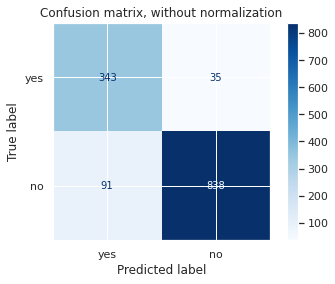

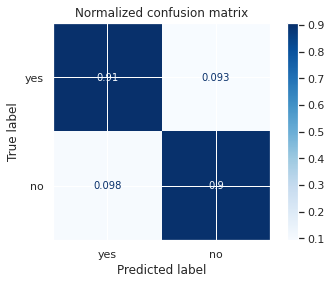

In [17]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import metrics 
from sklearn.metrics import plot_confusion_matrix


#print(type(X_train))
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

#print(X_train.shape, y_train.shape)
#print(len(X_train))

# making predictions on the testing set 
#y_pred = gnb.predict(X_test.reshape(-1, 1)) 


gnb = RandomForestClassifier() 
gnb.fit(X_train, y_train) 
y_pred = gnb.predict(X_test) 
  
# comparing actual response values (y_test) with predicted response values (y_pred) 
#y_test = y_test.transpose()
y_test = np.array(y_test)
#y_test = y_test.flatten()

#print(y_test)
#print(y_pred)
print("RANDOM FOREST CLASSIFIER model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

# THE END